# Setep 5: Machine Learning Model

<br>
In this step our Machine learning model will be created and its performance and accuracy will be evaluated using different parameters. Random Forest and Gradient-boosting were chosen to be used in the project

In [1]:
#Clean up any values left from any previous steps
def cleanup():
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
cleanup()

In [3]:
#Load Lemmatized Dataset from prevous steps
import pandas as pd

fields = ['Type', 'IE', 'NS', 'FT', 'PJ', 'Posts_Lemmatized']
mbti_Dataset = pd.read_pickle('mbti_Dataset2.pkl')
mbti_Dataset = mbti_Dataset.filter(fields)
mbti_Dataset.head()

,Type,IE,NS,FT,PJ,Posts_Lemmatized
0,INFJ,I,N,F,J,"[, moment, sportscenter, top, ten, play, prank..."
1,ENTP,E,N,T,P,"[finding, lack, post, alarming, sex, boring, p..."
2,INTP,I,N,T,P,"[good, one, course, say, know, blessing, curse..."
3,INTJ,I,N,T,J,"[dear, enjoyed, conversation, day, esoteric, g..."
4,ENTJ,E,N,T,J,"[fired, another, silly, misconception, approac..."


## 5-1: Split our data into training and test

In this part we are splitting our Dataset into Training and Test dataset. Test size is 20%.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(mbti_Dataset['Posts_Lemmatized'], mbti_Dataset[['IE' , 'NS', 'FT', 'PJ']], test_size=0.2)#20% of dataset is test set    

#Save Training and Test dataset in Picklet format.
X_train.to_pickle('X_train.pkl')
X_test.to_pickle('X_test.pkl')
Y_train.to_pickle('Y_train.pkl')
Y_test.to_pickle('Y_test.pkl')

Now training and test dataset will be converted to TFIDF, CountVectorizer and N-Grams(Same approad as step3 was used here). The result will be saved so it can be used in later steps. 

In [5]:
#Converting data to TFIDF, CountVectorizer and N-Grams. The result will be saved so it can be used in later steps. 
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from scipy import sparse
import pandas as pd

def lemmatizing(text):
    """Lemmatizing the input text using WordNet and NLTK package"""
    NLTK_WNL = nltk.WordNetLemmatizer()
    text_Lem = [NLTK_WNL.lemmatize(word) for word in text]
    return(text_Lem)


def clean_and_load():
    """Delete all variables inside memory and load training and test dataset"""
    for name in dir():
        if not name.startswith('_'):
            del globals()[name]
    global X_train, X_test, Y_train, Y_test
    X_train = pd.read_pickle('X_train.pkl')
    X_test = pd.read_pickle('X_test.pkl')
    Y_train = pd.read_pickle('Y_train.pkl')
    Y_test = pd.read_pickle('Y_test.pkl')


#TFIDF
clean_and_load()
tfidf_vect = TfidfVectorizer(analyzer=lemmatizing)
tfidf_vect_fit = tfidf_vect.fit(X_train)

tfidf_train = tfidf_vect_fit.transform(X_train)
tfidf_test = tfidf_vect_fit.transform(X_test)

X_train_tfidf = pd.DataFrame(tfidf_train.toarray())
X_test_tfidf = pd.DataFrame(tfidf_test.toarray())

np.save('X_train_tfidf', X_train_tfidf)#Saving results
np.save('X_test_tfidf', X_test_tfidf)#Saving results



#CountVectorizer
clean_and_load()
count_vect = CountVectorizer(analyzer=lemmatizing)
count_vect_fit = count_vect.fit(X_train)

count_train = count_vect_fit.transform(X_train)
count_test = count_vect_fit.transform(X_test)

X_train_count = pd.DataFrame(count_train.toarray())
X_test_count = pd.DataFrame(count_test.toarray())

np.save('X_train_count', X_train_count)#Saving results
np.save('X_test_count', X_test_count)#Saving results


#N-gram
#clean_and_load()
#ngram_vect = CountVectorizer(ngram_range=(1,3)) #Running N-Gram on full dataset (Max = 3)
#X_train = X_train.apply(lambda x: ' '.join(map(str,x)))
#X_test = X_test.apply(lambda x: ' '.join(map(str,x)))
#ngram_vect_fit = ngram_vect.fit(X_train)

#ngram_train = ngram_vect_fit.transform(X_train)
#ngram_test = ngram_vect_fit.transform(X_test)

#X_train_ngram = pd.DataFrame(ngram_train.toarray())
#X_test_ngram = pd.DataFrame(ngram_test.toarray())

#np.save('X_train_ngram', X_train_ngram)#Saving results
#np.save('D:\X_test_ngram', X_test_ngram)#Saving results


Since the result for N-Grams(3-Grams) was over 300GB, we are tuning our parameters on CountVectorizer and TFIDF.

## 5-1: Random Forest Model
### 5-1-1: Explorering Random Forest with Holdout test set + grid-search
In this step, various parameters are being used on our train dataset to find the best parameter for our Random Forest model. (Number of estimator, Maximum depth)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', None, 'display.max_colwidth', 500)


def rfClassifier_GridSearch(X_test_set, X_train_set, Lable, n_est, depth, feature_type, is_print = True):
    """This function will get number of estimators and depth as input return  Precision, recall and Accuracy for a given dataset and lable"""
    if Lable == 'IE':
        s_Lable = 'I'
        predict_Lable = 'Introverts'
    elif Lable == 'NS':
        s_Lable = 'N'
        predict_Lable = 'Intuitives'
    elif Lable == 'FT':
        s_Lable = 'F'
        predict_Lable = 'Feelers'
    elif Lable == 'PJ':
        s_Lable = 'P'
        predict_Lable = 'Perceivers'

    rf = RandomForestClassifier(n_estimators=n_est, max_depth=depth ,n_jobs=-1)#Max depth of tree is 20
    rf_model = rf.fit(X_train_set, Y_train[Lable])
    Y_pred = rf_model.predict(X_test_set)

    precision, recall, fscore, support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')
    if is_print:
        print('Being ' + predict_Lable + ' using ' + feature_type + ':'  ,
        'Estimators: {} / Max_Depth: {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                        n_est,
                                                        depth,
                                                        round(precision, 3),
                                                        round(recall, 3), 
                                                        round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    return([predict_Lable, feature_type, n_est, depth, precision, recall, round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)])


classes = ['IE' , 'NS', 'FT', 'PJ']
rf_result = []

Y_train = pd.read_pickle('Y_train.pkl')
Y_test = pd.read_pickle('Y_test.pkl')

#Nested loop to check different values on different features/classes to find the best parameters
for feature_type in ['TFIDF', 'CountVectorizer']:
    if feature_type == 'TFIDF':
        X_test_set = np.load('X_test_tfidf.npy')
        X_train_set = np.load('X_train_tfidf.npy')
    elif feature_type == 'CountVectorizer':
        X_test_set = np.load('X_test_count.npy')
        X_train_set = np.load('X_train_count.npy')
    #elif feature_type == 'N-gram':
        #X_test_set = np.load('X_test_ngram.npy')
        #X_train_set = np.load('X_train_ngram.npy')
    for item in classes:
        for n_est in [10, 50, 100, 200, 500]:
            for depth in [5, 10, 20, 30, None]:
                rf_result.append(rfClassifier_GridSearch(X_test_set = X_test_set, X_train_set = X_train_set, Lable = item, n_est=n_est, depth=depth, feature_type=feature_type,is_print = False))


pd.DataFrame(rf_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Precision', 'Recall', 'Accuracy']).to_csv('RF_Holdout_Result.csv')

Checking the result to find best parameters for our Grid Search:

In [10]:
from tabulate import tabulate

df = pd.read_csv('RF_Holdout_Result.csv')[['Type', 'Method', 'Estimators', 'Max_Depth', 'Precision', 'Recall', 'Accuracy']]
print(df[df['Method'] == 'TFIDF'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown(), '\n')
print(df[df['Method'] == 'CountVectorizer'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown())

|    | Type       | Method   |   Estimators |   Max_Depth |   Precision |   Recall |   Accuracy |
|---:|:-----------|:---------|-------------:|------------:|------------:|---------:|-----------:|
| 25 | Intuitives | TFIDF    |           10 |           5 |    0.855331 | 1        |      0.855 |
| 74 | Feelers    | TFIDF    |          500 |         nan |    0.726962 | 0.890282 |      0.755 |
|  3 | Introverts | TFIDF    |           10 |          30 |    0.75522  | 0.996937 |      0.754 |
| 89 | Perceivers | TFIDF    |          100 |         nan |    0.649166 | 0.974954 |      0.657 | 

|     | Type       | Method          |   Estimators |   Max_Depth |   Precision |   Recall |   Accuracy |
|----:|:-----------|:----------------|-------------:|------------:|------------:|---------:|-----------:|
| 129 | Intuitives | CountVectorizer |           10 |         nan |    0.856647 | 0.998652 |      0.856 |
| 104 | Introverts | CountVectorizer |           10 |         nan |    0.760355 | 0.98392  |

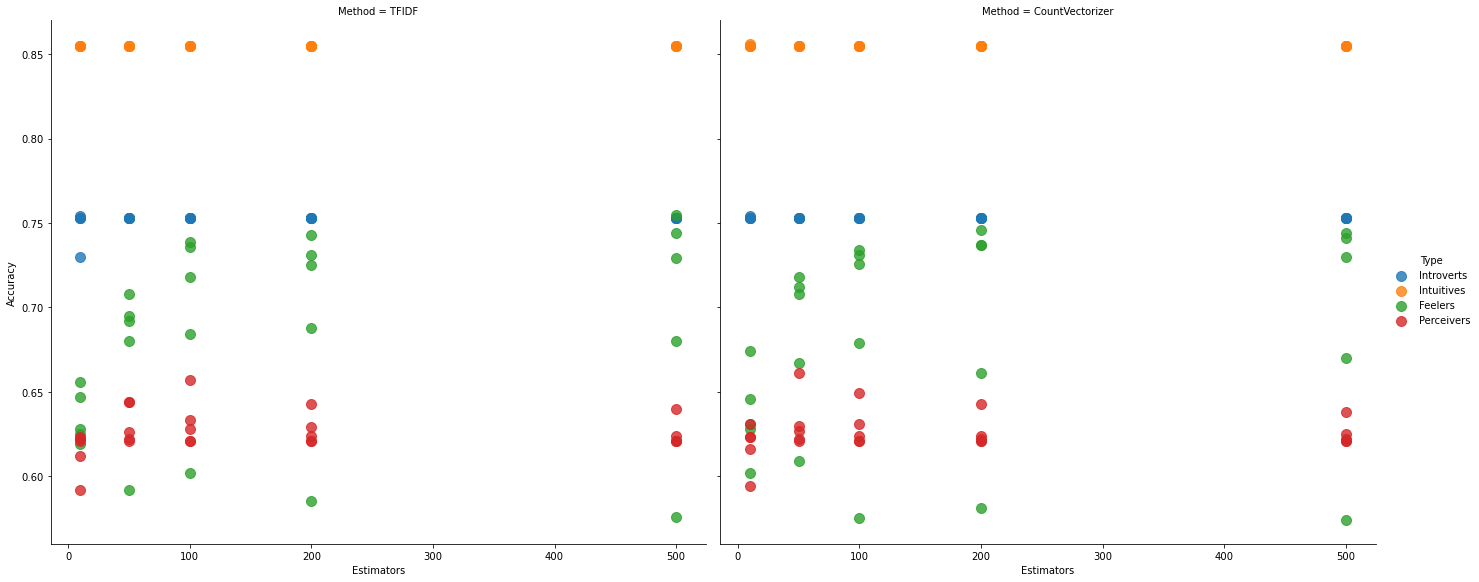

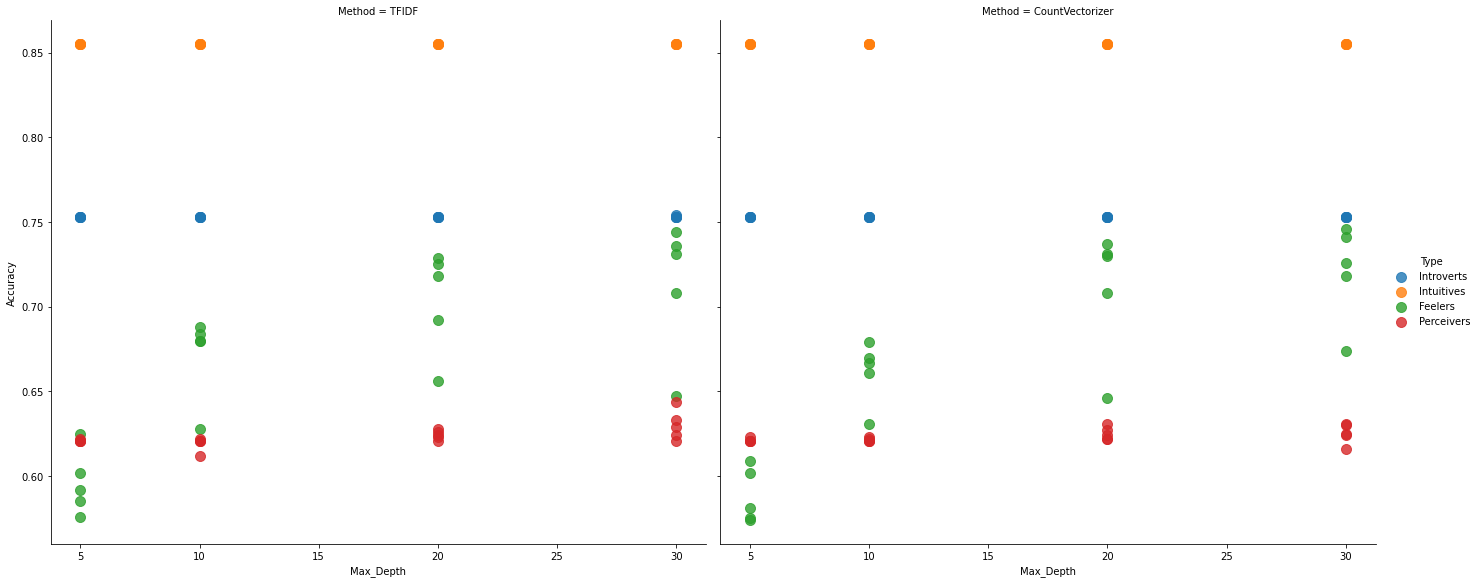

In [9]:
import seaborn as sns
from pandas import DataFrame

df = pd.read_csv('RF_Holdout_Result.csv')

sns.lmplot(x='Estimators', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 8, scatter_kws={"s": 100}, col = 'Method')
sns.lmplot(x='Max_Depth', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 8, scatter_kws={"s": 100}, col = 'Method')

#### Based on the results , Max_Depth increases accuracy specially for Feelers and Perceivers groups. In general TFID is slightly bettrer. Therefor evaluation Random forest model using TFIDF and  Max_Depth as 5 and 30 and Non and also Number of estimators 500, 100 and 10.

### 5-1-2 : Train vectorizes on training set and use that to transform test set.

5 fold validation is being used here:

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
#from scipy import sparse
import numpy as np

pd.set_option('display.max_colwidth', 500)

def RF_Evaluation(param, Lable, is_print = True):
    rf = RandomForestClassifier()
    gs = GridSearchCV(rf, param, cv=5)#cv=5 means 5 folde validation
    gs_fit = gs.fit(X_train_set, Y_train[Lable])
    
    if is_print:
        print(pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[['param_max_depth',
        'param_n_estimators', 'std_test_score', 'mean_test_score', 'rank_test_score']][0:5])

    return(pd.DataFrame(gs_fit.cv_results_))



#Base on the results from previous steps
param = {'n_estimators' : [10, 100, 500],
        'max_depth' : [30, None]}

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train.pkl')
rf_parm_result = []


for feature_type in ['TFIDF']:#Only using TFID based on the result from previous steps
    #if feature_type == 'TFIDF':
    X_train_set = np.load('X_train_tfidf.npy')
    #elif feature_type == 'CountVectorizer':
    #    X_train_set = np.load('X_train_count.npy')
    #elif feature_type == 'N-gram':
    #    X_train_set = np.load('X_train_ngram.npy')
    for item in classes:
        temp_DF = RF_Evaluation(param, Lable = item, is_print = False)
        temp_DF.insert(0, 'Feature', feature_type)
        temp_DF.insert(1, 'Class', item)
        rf_parm_result.append(temp_DF)
        pd.concat(rf_parm_result).to_csv('RF_Parm_Result.csv')

pd.concat(rf_parm_result).to_csv('RF_Parm_Result.csv')


In [63]:
df = pd.read_csv('RF_Parm_Result.csv')
print(df[['Feature', 'Class', 'param_max_depth', 'param_n_estimators', 'mean_test_score', 'rank_test_score']].sort_values(['rank_test_score'], ascending = True).groupby(['Class']).head(1).to_markdown(), '\n')

|    | Feature   | Class   |   param_max_depth |   param_n_estimators |   mean_test_score |   rank_test_score |
|---:|:----------|:--------|------------------:|---------------------:|------------------:|------------------:|
|  0 | TFIDF     | IE      |                30 |                   10 |          0.774207 |                 1 |
| 17 | TFIDF     | FT      |               nan |                  500 |          0.752594 |                 1 |
| 22 | TFIDF     | PJ      |               nan |                  100 |          0.629827 |                 1 |
|  9 | TFIDF     | NS      |               nan |                   10 |          0.863833 |                 1 | 



## 5-2: Gradient Boosting Model
### 5-2-1: Gradient Boosting with Holdout test set

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
#from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd
import numpy as np
from datetime import datetime


pd.set_option('display.max_rows', None, 'display.max_colwidth', 500)


def GBoosting_GridSearch(Lable, n_est, depth, lr, feature_type, is_print = True):
    if Lable == 'IE':
        s_Lable = 'I'
        predict_Lable = 'Introverts'
    elif Lable == 'NS':
        s_Lable = 'N'
        predict_Lable = 'Intuitives'
    elif Lable == 'FT':
        s_Lable = 'F'
        predict_Lable = 'Feelers'
    elif Lable == 'PJ':
        s_Lable = 'P'
        predict_Lable = 'Perceivers'

    gb = GradientBoostingClassifier(n_estimators=n_est, max_depth=depth , learning_rate=lr)
    gb_model = gb.fit(X_train_set, Y_train[Lable])
    Y_pred = gb_model.predict(X_test_set)

    precision, recall, fscore, support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')
    if is_print:
        print('Being ' + predict_Lable + ' using ' + feature_type + ': '  ,'Estimators: {} / Max_Depth: {} / Learning_Rate: {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                        n_est,
                                                        depth,
                                                        lr,
                                                        round(precision, 3),
                                                        round(recall, 3), 
                                                        round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    return([predict_Lable, feature_type, n_est, depth, lr, precision, recall, round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)])



#classes = ['IE' , 'NS', 'FT', 'PJ']
classes = ['IE']#Only IE was calculated due to expensive computation
gb_result = []

Y_train = pd.read_pickle('Y_train.pkl')
Y_test = pd.read_pickle('Y_test.pkl')



#for feature_type in ['TFIDF', 'CountVectorizer']:
for feature_type in ['TFIDF']:
    if feature_type == 'TFIDF':
        X_test_set = np.load('X_test_tfidf.npy')
        X_train_set = np.load('X_train_tfidf.npy')
    elif feature_type == 'CountVectorizer':
        X_test_set = np.load('X_test_count.npy')
        X_train_set = np.load('X_train_count.npy')
    #elif feature_type == 'N-gram':
        #X_test_set = np.load('X_test_ngram.npy')
        #X_train_set = np.load('X_train_ngram.npy')
        #print()
    for item in classes:
        for n_est in [50, 100, 150]:
            for depth in [3, 7, 11, 15]:
                for lr in [0.01, 0.10, 1.00]:
                    gb_result.append(GBoosting_GridSearch(Lable = item, n_est=n_est, depth=depth, lr = lr, feature_type=feature_type))
                    pd.DataFrame(gb_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Learning_Rate','Precision', 'Recall', 'Accuracy']).to_csv('GB_Holdout_Result-IE2.csv')

pd.DataFrame(gb_result, columns= ['Type', 'Method', 'Estimators', 'Max_Depth', 'Learning_Rate','Precision', 'Recall', 'Accuracy']).to_csv('GB_Holdout_Result-IE2.csv')


#### **Note:** The above function calculation needs a lot of time. The Parameter tunning was calculated for TFIDF and only for IE type:

In [16]:
from tabulate import tabulate

df = pd.read_csv('GB_Holdout_Result.csv')
print(df[df['Type'] == 'Introverts'].sort_values(['Accuracy', 'Type'], ascending = False).head(1).to_markdown(), '\n')
#print(df[df['Method'] == 'CountVectorizer'].sort_values(['Accuracy', 'Type'], ascending = False).groupby(['Type']).head(1).to_markdown())

|    |   Column1 | Type       | Method   |   Estimators |   Max_Depth |   Learning_Rate |   Precision |   Recall |   Accuracy |
|---:|----------:|:-----------|:---------|-------------:|------------:|----------------:|------------:|---------:|-----------:|
| 11 |        13 | Introverts | TFIDF    |          100 |           3 |             0.1 |    0.814406 | 0.960949 |      0.806 | 



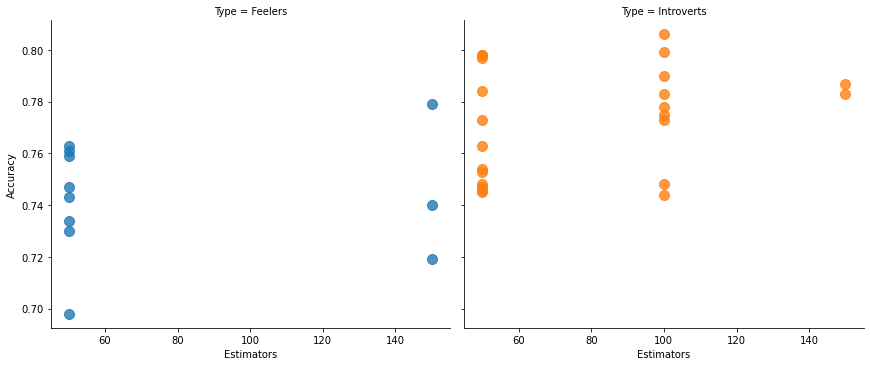

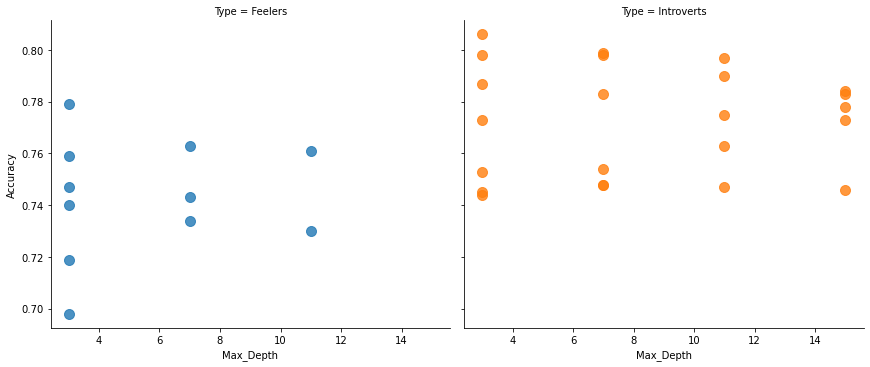

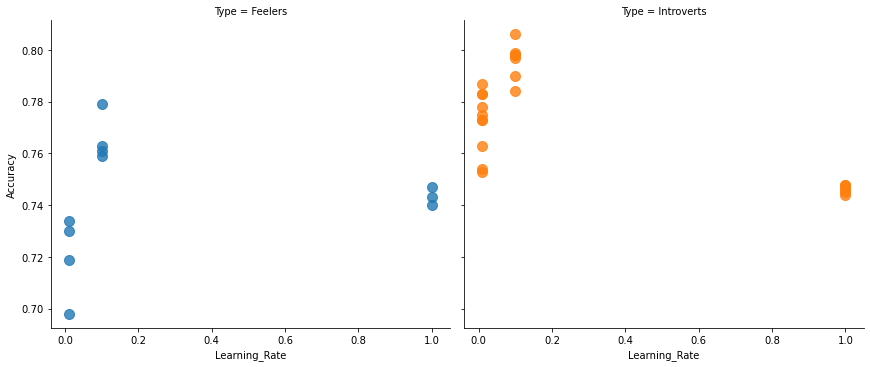

In [20]:
import seaborn as sns
from pandas import DataFrame

df = pd.read_csv('GB_Holdout_Result.csv')

sns.lmplot(x='Estimators', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')
sns.lmplot(x='Max_Depth', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')
sns.lmplot(x='Learning_Rate', y='Accuracy', data=df, hue='Type', fit_reg=False, aspect=1.2, height = 5, scatter_kws={"s": 100}, col = 'Type')

### 5-2-2: Evaluation Gradient Boosting Model

In [9]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np

pd.set_option('display.max_colwidth', 500)


def GB_Evaluation(param, Lable, is_print = True):
    gb = GradientBoostingClassifier()
    gs = GridSearchCV(gb, param, cv=5)#cv=5 meand 5 folde validation
    gs_fit = gs.fit(X_train_set, Y_train[Lable])

    if is_print:
        print(pd.DataFrame(gs_fit.cv_results_).sort_values('mean_test_score', ascending = False)[['param_max_depth', 
        'param_n_estimators', 'param_learning_rate','std_test_score', 'mean_test_score', 'rank_test_score']][0:5])

    return(pd.DataFrame(gs_fit.cv_results_))
  
param = {'n_estimators' : [100],
                'max_depth' : [3],
                'learning_rate' : [0.1]}

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train.pkl')
gb_parm_result = []


for feature_type in ['TFIDF']::#Only using TFID based on the result from previous steps
    #if feature_type == 'TFIDF':
    X_train_set = np.load('X_train_tfidf.npy')
    #elif feature_type == 'CountVectorizer':
    #    X_train_set = np.load('X_train_count.npy')
    #elif feature_type == 'N-gram':
        #X_train_set = np.load('X_train_ngram.npy')
    for item in classes:
        temp_DF = GB_Evaluation(param, Lable = item, is_print = False)
        temp_DF.insert(0, 'Feature', feature_type)
        temp_DF.insert(1, 'Class', item)
        gb_parm_result.append(temp_DF)
        pd.concat(gb_parm_result).to_csv('GB_Parm_Result.csv')

pd.concat(gb_parm_result).to_csv('GB_Parm_Result.csv')

In [14]:
df = pd.read_csv('GB_Parm_Result.csv')
print(df[['Feature', 'Class', 'param_max_depth', 'param_n_estimators', 'param_learning_rate', 'mean_test_score', 'rank_test_score']]
    .sort_values(['rank_test_score'], ascending = True)
    .groupby(['Class']).head(1).to_markdown(), '\n')

|    | Feature   | Class   |   param_max_depth |   param_n_estimators |   param_learning_rate |   mean_test_score |   rank_test_score |
|---:|:----------|:--------|------------------:|---------------------:|----------------------:|------------------:|------------------:|
|  0 | TFIDF     | IE      |                 3 |                  100 |                   0.1 |          0.774207 |                 1 |
|  1 | TFIDF     | NS      |                 3 |                  100 |                   0.1 |          0.863689 |                 1 |
|  2 | TFIDF     | FT      |                 3 |                  100 |                   0.1 |          0.630403 |                 1 |
|  3 | TFIDF     | PJ      |                 3 |                  100 |                   0.1 |          0.590202 |                 1 | 



## Final evaluation of models

In [24]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import math

Y_train = pd.read_pickle('Y_train.pkl')
Y_test = pd.read_pickle('Y_test.pkl')
X_train_tfidf = np.load('X_train_tfidf.npy')
X_test_tfidf = np.load('X_test_tfidf.npy')

df = pd.read_csv('RF_Parm_Result.csv')
df = df.sort_values(['rank_test_score'], ascending = True).groupby(['Class']).head(1)

def RF_Final_Eval(item):
    if item['Class'] == 'IE':
        Lable, s_Lable, predict_Lable = 'IE', 'I', 'Introverts'
 
    elif item['Class'] == 'NS':
        Lable, s_Lable, predict_Lable = 'NS', 'N', 'Intuitives'

    elif item['Class'] == 'FT':
        Lable, s_Lable, predict_Lable = 'FT','F', 'Feelers'

    elif item['Class'] == 'PJ':
        Lable, s_Lable, predict_Lable = 'PJ','P', 'Perceivers'
    
    if math.isnan(item['param_max_depth']):
        item['param_max_depth'] = None

    rf = RandomForestClassifier(n_estimators=item['param_n_estimators'], max_depth=item['param_max_depth'], n_jobs=-1)

    start = time.time()
    rf_model = rf.fit(X_train_tfidf, Y_train[Lable])
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    Y_pred = rf_model.predict(X_test_tfidf)
    end = time.time()
    pred_time = (end - start)

    precision, recall, fscore, train_support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')

    print('{} --> Fit time: {} / Predict time: {} --> Estimator {} / Max_Depth {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                    predict_Lable,
                                                    round(fit_time, 3),
                                                    round(pred_time, 3),
                                                    item['param_n_estimators'],
                                                    item['param_max_depth'],
                                                    round(precision, 3),
                                                    round(recall, 3), 
                                                    round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))


for index, item in df.iterrows():
    RF_Final_Eval(item)


Introverts --> Fit time: 15.922 / Predict time: 0.686 --> Estimator 10 / Max_Depth 30.0 --> Precision: 0.755 / Recall: 0.997 / Accuracy: 0.754
Feelers --> Fit time: 293.472 / Predict time: 1.353 --> Estimator 500 / Max_Depth None --> Precision: 0.731 / Recall: 0.896 / Accuracy: 0.761
Perceivers --> Fit time: 90.712 / Predict time: 1.005 --> Estimator 100 / Max_Depth None --> Precision: 0.644 / Recall: 0.964 / Accuracy: 0.646
Intuitives --> Fit time: 38.441 / Predict time: 0.698 --> Estimator 10 / Max_Depth None --> Precision: 0.856 / Recall: 0.999 / Accuracy: 0.855


In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support as score
import time
import pandas as pd
import numpy as np
import math

classes = ['IE' , 'NS', 'FT', 'PJ']
Y_train = pd.read_pickle('Y_train.pkl')
Y_test = pd.read_pickle('Y_test.pkl')
X_train_tfidf = np.load('X_train_tfidf.npy')
X_test_tfidf = np.load('X_test_tfidf.npy')

df = pd.read_csv('GB_Parm_Result.csv')
df = df.sort_values(['rank_test_score'], ascending = True).groupby(['Class']).head(1)

def GB_Final_Eval(item):
    if item['Class'] == 'IE':
        Lable, s_Lable, predict_Lable = 'IE', 'I', 'Introverts'
 
    elif item['Class'] == 'NS':
        Lable, s_Lable, predict_Lable = 'NS', 'N', 'Intuitives'

    elif item['Class'] == 'FT':
        Lable, s_Lable, predict_Lable = 'FT','F', 'Feelers'

    elif item['Class'] == 'PJ':
        Lable, s_Lable, predict_Lable = 'PJ','P', 'Perceivers'
    
    if math.isnan(item['param_max_depth']):
        item['param_max_depth'] = None

    gb = GradientBoostingClassifier(n_estimators=item['param_n_estimators'], max_depth=item['param_max_depth'], learning_rate=item['param_learning_rate'])

    start = time.time()
    gb_model = gb.fit(X_train_tfidf,Y_train[Lable])
    end = time.time()
    fit_time = (end - start)

    start = time.time()
    Y_pred = gb_model.predict(X_test_tfidf)
    end = time.time()
    pred_time = (end - start)


    precision, recall, fscore, train_support = score(Y_test[Lable], Y_pred, pos_label=s_Lable, average='binary')

    print('{} --> Fit time: {} / Predict time: {} --> Estimator {} / Max_Depth {} Learning_Rate {} --> Precision: {} / Recall: {} / Accuracy: {}'.format(
                                                    predict_Lable,
                                                    round(fit_time, 3),
                                                    round(pred_time, 3),
                                                    item['param_n_estimators'],
                                                    item['param_max_depth'],
                                                    item['param_learning_rate'],
                                                    round(precision, 3),
                                                    round(recall, 3), 
                                                    round((Y_pred==Y_test[Lable]).sum() / len(Y_pred),3)))
    
for index, item in df.iterrows():
    GB_Final_Eval(item)
                                                        

Introverts --> Fit time: 9622.716 / Predict time: 1.512 --> Estimator 100 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.811 / Recall: 0.963 / Accuracy: 0.803
Intuitives --> Fit time: 9203.561 / Predict time: 1.477 --> Estimator 100 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.879 / Recall: 0.987 / Accuracy: 0.872
Feelers --> Fit time: 8404.493 / Predict time: 1.491 --> Estimator 100 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.802 / Recall: 0.796 / Accuracy: 0.779
Perceivers --> Fit time: 8788.094 / Predict time: 1.502 --> Estimator 100 / Max_Depth 3 Learning_Rate 0.1 --> Precision: 0.752 / Recall: 0.903 / Accuracy: 0.754


Results for each model and type without adding any new features from step 4 to our model.

| Model             | Type         | Fit_Time | Predict_Time | Percision | Recall | Accuracy |
|-------------------|--------------|----------|--------------|-----------|--------|----------|
| decision_tree     | Introversion | 15.922   | 0.686        | 0.755     | 0.997  | 0.754    |
| gradient_boosting | Introversion | 9622.716 | 1.512        | 0.811     | 0.963  | 0.803    |
| decision_tree     | Feeling      | 293.472  | 1.353        | 0.731     | 0.896  | 0.761    |
| gradient_boosting | Feeling      | 8404.493 | 1.491        | 0.802     | 0.796  | 0.779    |
| decision_tree     | Intuition    | 38.441   | 0.698        | 0.856     | 0.999  | 0.855    |
| gradient_boosting | Intuition    | 9203.561 | 1.477        | 0.879     | 0.987  | 0.872    |
| decision_tree     | Perceiving   | 90.712   | 1.005        | 0.644     | 0.964  | 0.646    |
| gradient_boosting | Perceiving   | 8788.094 | 1.502        | 0.752     | 0.903  | 0.754    |



GBoosting has a higher accuracy and significantly higher fitting time, whereas Decision Tree fitting time is lower.  Predicting time for GBoosting is slightly higher, but not significantly different.